In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

# Deep learning and embeddings
import faiss
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

# Text processing
import re
import nltk
from collections import Counter

# Set random seeds for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("🇮🇩 Indonesian Product Reviews Sentiment Analysis")
print("=" * 60)
print("Libraries imported successfully!")

🇮🇩 Indonesian Product Reviews Sentiment Analysis
Libraries imported successfully!


In [2]:
print("Loading Dataset from Hugging Face...")

# Load the dataset
try:
    dataset = load_dataset("dipawidia/ecommerce-product-reviews-sentiment", "default", split="train")
    df_raw = dataset.to_pandas()
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    df_raw = None

if df_raw is not None:
    print(f"Dataset Overview:")
    print(f"Shape: {df_raw.shape}")
    print(f"Columns: {list(df_raw.columns)}")
    print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Loading Dataset from Hugging Face...
Dataset loaded successfully!
Dataset Overview:
Shape: (11606, 3)
Columns: ['review', 'translate', 'sentimen']
Memory usage: 4.38 MB


In [3]:
print("Basic Data Exploration")
print("=" * 40)

# Display first few rows
print("First 5 rows:")
display(df_raw.head())

print("Dataset Information:")
print(df_raw.info())

print("Basic Statistics:")
print(df_raw.describe(include='all'))

# Check for missing values
print("Missing Values:")
missing_data = df_raw.isnull().sum()
print(missing_data)

if missing_data.sum() > 0:
    # Visualize missing data
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_raw.isnull(), cbar=True, cmap='viridis')
    plt.title('Missing Data Heatmap')
    plt.show()

Basic Data Exploration
First 5 rows:


,review,translate,sentimen
0,Suara dan mic puas. Hanya saya pesan yg nyala ...,sound and mic satisfied. I only ordered the on...,0
1,Good. Mudah-mudahan awet. Makasih,good. hopefully durable. Thanks,1
2,"kondisi dus robek2, tolong di perhatikan lagi","the condition of the box is torn, please pay a...",0
3,Kualitas produk baik. Harga terjangkau dan pen...,product quality is good. affordable prices and...,0
4,"Overall bagus, tombol berfungsi semuanya, tapi...","overall is good, the buttons all work, but the...",0


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11606 entries, 0 to 11605
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     11606 non-null  object
 1   translate  11606 non-null  object
 2   sentimen   11606 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 272.1+ KB
None
Basic Statistics:
                          review translate      sentimen
count                      11606     11606  11606.000000
unique                     11599     11584           NaN
top     pengiriman lumayan cepat      nice           NaN
freq                           2         2           NaN
mean                         NaN       NaN      0.500000
std                          NaN       NaN      0.500022
min                          NaN       NaN      0.000000
25%                          NaN       NaN      0.000000
50%                          NaN       NaN      0.500000
75%                          Na

Target Variable Analysis
Sentiment Distribution:
Negative (0): 5803 (50.0%)
Positive (1): 5803 (50.0%)


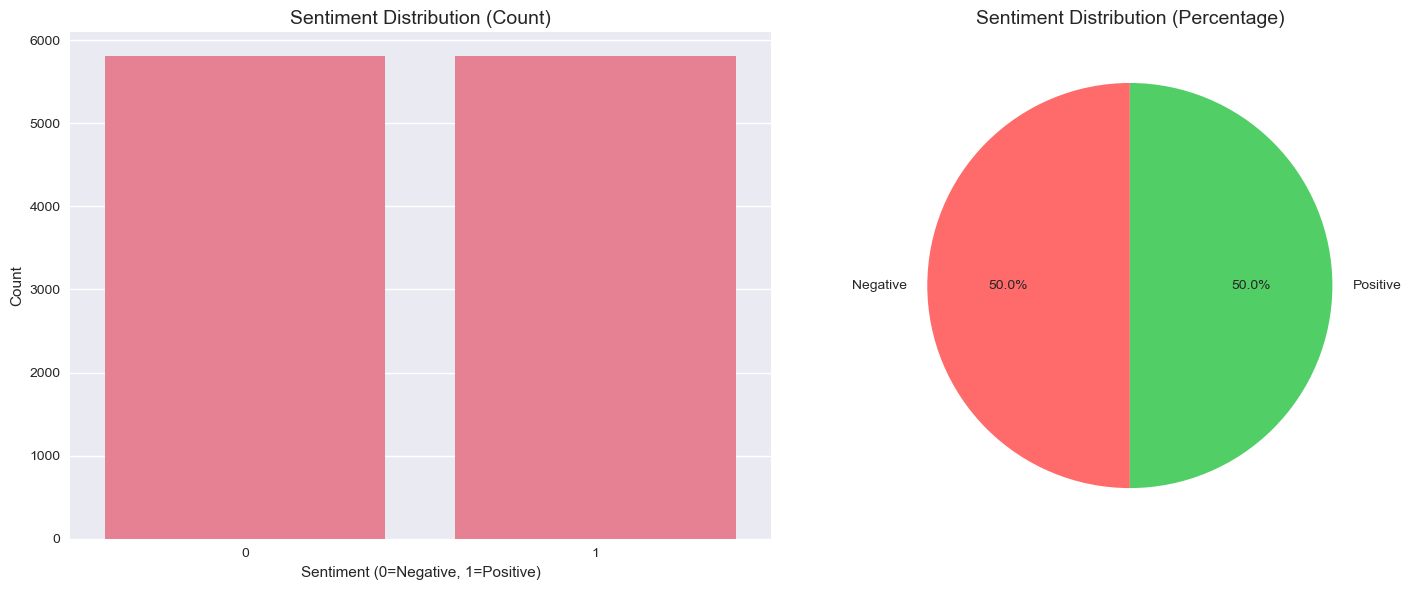

Class Balance Ratio: 1.000
Dataset is relatively balanced


In [4]:
print("Target Variable Analysis")
print("=" * 40)

# Sentiment distribution
sentiment_counts = df_raw['sentimen'].value_counts()
sentiment_percentages = df_raw['sentimen'].value_counts(normalize=True) * 100

print("Sentiment Distribution:")
print(f"Negative (0): {sentiment_counts[0]} ({sentiment_percentages[0]:.1f}%)")
print(f"Positive (1): {sentiment_counts[1]} ({sentiment_percentages[1]:.1f}%)")

# Visualize sentiment distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Count plot
sns.countplot(data=df_raw, x='sentimen', ax=ax1)
ax1.set_title('Sentiment Distribution (Count)', fontsize=14)
ax1.set_xlabel('Sentiment (0=Negative, 1=Positive)')
ax1.set_ylabel('Count')

# Percentage pie chart
labels = ['Negative', 'Positive']
colors = ['#ff6b6b', '#51cf66']
ax2.pie(sentiment_counts.values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Sentiment Distribution (Percentage)', fontsize=14)

plt.tight_layout()
plt.show()

# Check for class imbalance
imbalance_ratio = sentiment_counts.min() / sentiment_counts.max()
print(f"Class Balance Ratio: {imbalance_ratio:.3f}")
if imbalance_ratio < 0.8:
    print("Dataset shows class imbalance - consider balancing techniques")
else:
    print("Dataset is relatively balanced")

Text Data Exploration
Text Length Statistics:
       review_length  review_word_count
count   11606.000000       11606.000000
mean      103.572032          15.756591
std        92.148305          14.412383
min         1.000000           1.000000
25%        46.000000           7.000000
50%        78.000000          12.000000
75%       131.000000          20.000000
max      1668.000000         235.000000


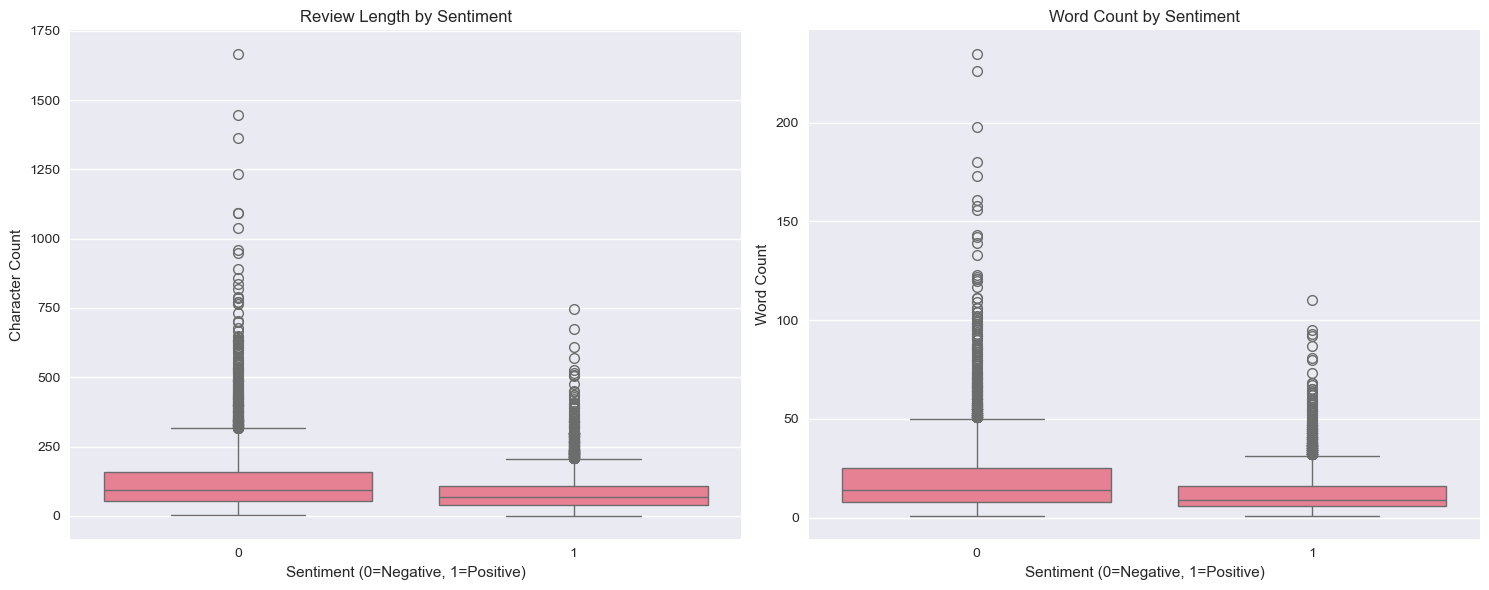

Sample Reviews by Sentiment:
Negative Reviews:
1. Suara dan mic puas. Hanya saya pesan yg nyala dan sudah sy pastikan lg klik yg nyala tp yg datang ga...
2. kondisi dus robek2, tolong di perhatikan lagi...
3. Kualitas produk baik. Harga terjangkau dan pengirimannya cepet banget. Udh 3x order disini oke lah t...
Positive Reviews:
1. Good. Mudah-mudahan awet. Makasih ...
2. Produk ini original, Dan kualitasnya sangat baik. kecepatan pengiriman sanagt cepat, recommended sel...
3. terimakasih banyak ka ya, barang sudah diterima dengan baik. sukses terus ka...


In [5]:
print("Text Data Exploration")
print("=" * 40)

# Text length analysis
df_raw['review_length'] = df_raw['review'].str.len()
df_raw['review_word_count'] = df_raw['review'].str.split().str.len()

print("Text Length Statistics:")
print(df_raw[['review_length', 'review_word_count']].describe())

# Visualize text lengths by sentiment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Review length distribution
sns.boxplot(data=df_raw, x='sentimen', y='review_length', ax=ax1)
ax1.set_title('Review Length by Sentiment')
ax1.set_xlabel('Sentiment (0=Negative, 1=Positive)')
ax1.set_ylabel('Character Count')

# Word count distribution
sns.boxplot(data=df_raw, x='sentimen', y='review_word_count', ax=ax2)
ax2.set_title('Word Count by Sentiment')
ax2.set_xlabel('Sentiment (0=Negative, 1=Positive)')
ax2.set_ylabel('Word Count')

plt.tight_layout()
plt.show()

# Show sample reviews by sentiment
print("Sample Reviews by Sentiment:")
print("Negative Reviews:")
negative_samples = df_raw[df_raw['sentimen'] == 0]['review'].head(3)
for i, review in enumerate(negative_samples, 1):
    print(f"{i}. {review[:100]}...")

print("Positive Reviews:")
positive_samples = df_raw[df_raw['sentimen'] == 1]['review'].head(3)
for i, review in enumerate(positive_samples, 1):
    print(f"{i}. {review[:100]}...")

Data Cleaning and Preprocessing
Cleaning text data...
Removed 4 duplicate rows
Removed 4 rows with missing values
Removed short texts, final dataset: 11556 samples
Data cleaning completed!
Final dataset shape: (11556, 8)
Sentiment distribution after cleaning:
sentimen
0    5788
1    5768
Name: count, dtype: int64


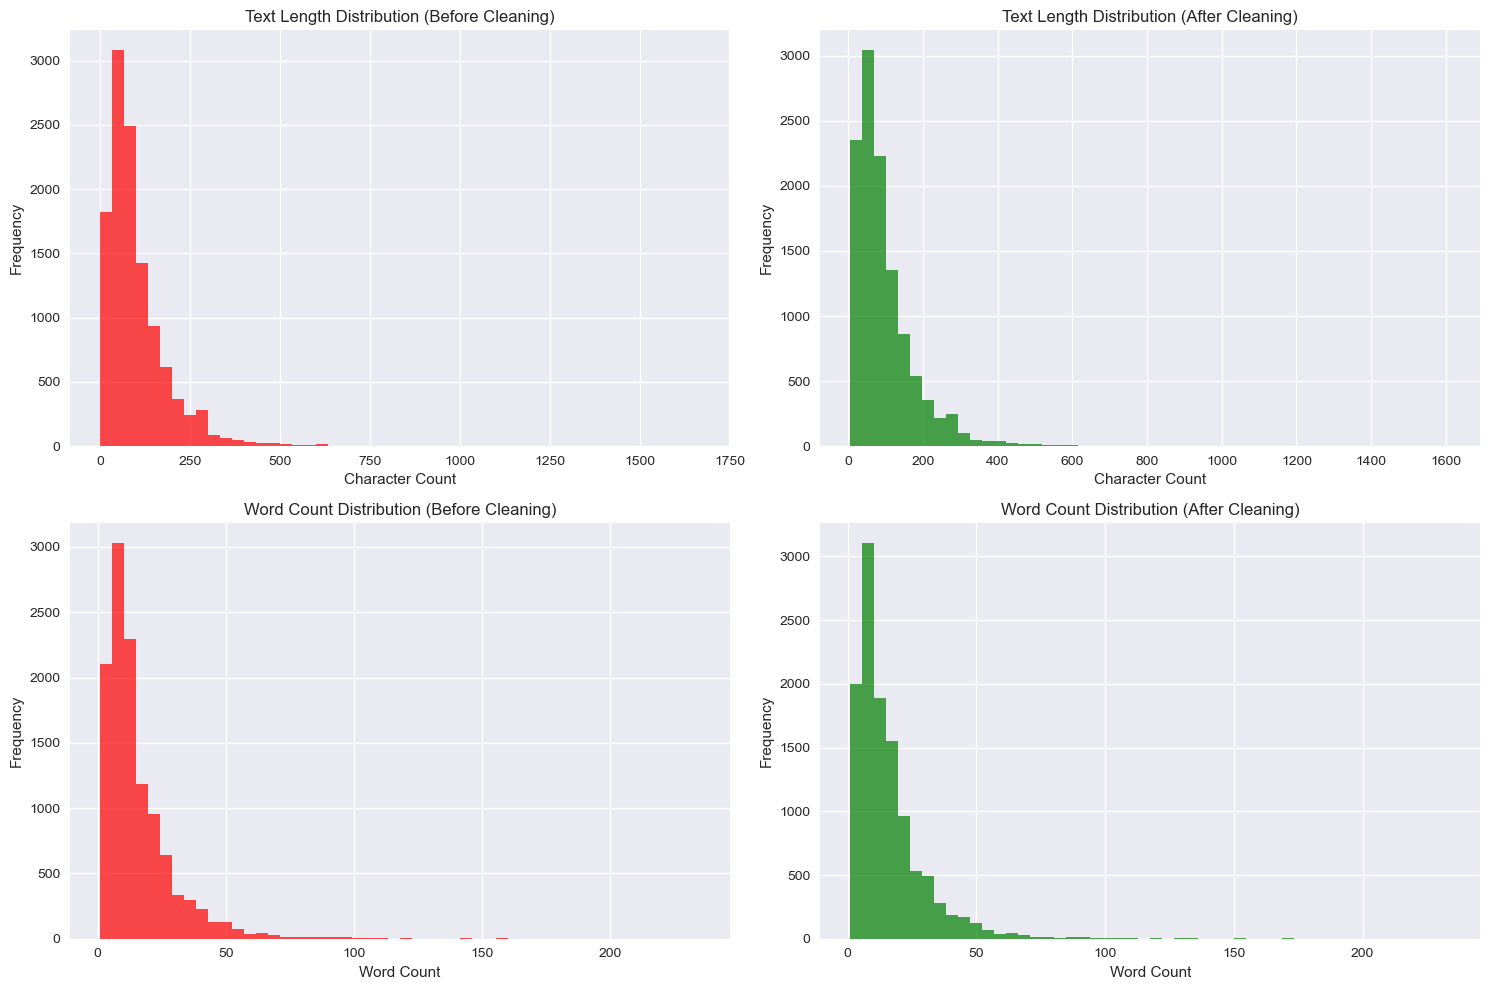

In [6]:
print("Data Cleaning and Preprocessing")
print("=" * 40)

def clean_text(text):
    """Enhanced text cleaning for Indonesian text"""
    if pd.isna(text):
        return ""
    
    text = str(text).strip()
    
    # Remove special characters but keep Indonesian words
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    
    return text.lower().strip()

# Apply cleaning
print("Cleaning text data...")
df_clean = df_raw.copy()

# Remove duplicates
initial_count = len(df_clean)
df_clean = df_clean.drop_duplicates()
print(f"Removed {initial_count - len(df_clean)} duplicate rows")

# Remove missing values
df_clean = df_clean.dropna()
print(f"Removed {initial_count - len(df_clean)} rows with missing values")

# Clean text
df_clean['review_clean'] = df_clean['review'].apply(clean_text)

# Remove very short texts
df_clean = df_clean[df_clean['review_clean'].str.len() > 5]
print(f"Removed short texts, final dataset: {len(df_clean)} samples")

# Update text statistics
df_clean['clean_length'] = df_clean['review_clean'].str.len()
df_clean['clean_word_count'] = df_clean['review_clean'].str.split().str.len()

print(f"Data cleaning completed!")
print(f"Final dataset shape: {df_clean.shape}")
print(f"Sentiment distribution after cleaning:")
print(df_clean['sentimen'].value_counts())

# Compare before and after cleaning
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Before cleaning
ax1.hist(df_raw['review_length'], bins=50, alpha=0.7, color='red')
ax1.set_title('Text Length Distribution (Before Cleaning)')
ax1.set_xlabel('Character Count')
ax1.set_ylabel('Frequency')

# After cleaning
ax2.hist(df_clean['clean_length'], bins=50, alpha=0.7, color='green')
ax2.set_title('Text Length Distribution (After Cleaning)')
ax2.set_xlabel('Character Count')
ax2.set_ylabel('Frequency')

# Word count before
ax3.hist(df_raw['review_word_count'], bins=50, alpha=0.7, color='red')
ax3.set_title('Word Count Distribution (Before Cleaning)')
ax3.set_xlabel('Word Count')
ax3.set_ylabel('Frequency')

# Word count after
ax4.hist(df_clean['clean_word_count'], bins=50, alpha=0.7, color='green')
ax4.set_title('Word Count Distribution (After Cleaning)')
ax4.set_xlabel('Word Count')
ax4.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
import torch
print(torch.cuda.is_available())  # True kalau GPU bisa dipakai

True


In [8]:
print("Loading Sentence Transformer Model")
print("=" * 40)

# Load the multilingual model for Indonesian text
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
print(f"Loading model: {model_name}")

try:
    model = SentenceTransformer(model_name, device="cuda")
    print(f"Model loaded successfully!")
    print(f"Embedding dimension: {model.get_sentence_embedding_dimension()}")
    
    # Test the model with a sample
    test_text = "Produk ini sangat bagus!"
    test_embedding = model.encode([test_text])
    print(f"Test embedding shape: {test_embedding.shape}")
    
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

Loading Sentence Transformer Model
Loading model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Model loaded successfully!
Embedding dimension: 768
Test embedding shape: (1, 768)


Generating Embeddings
Generating embeddings for all reviews...
Processing 11556 reviews...


Batches:   0%|          | 0/91 [00:00<?, ?it/s]

Embeddings generated successfully!
Embeddings shape: (11556, 768)
Memory usage: 33.86 MB
Embedding Statistics:
Mean: 0.001328
Std: 0.036060
Min: -0.262788
Max: 0.378542


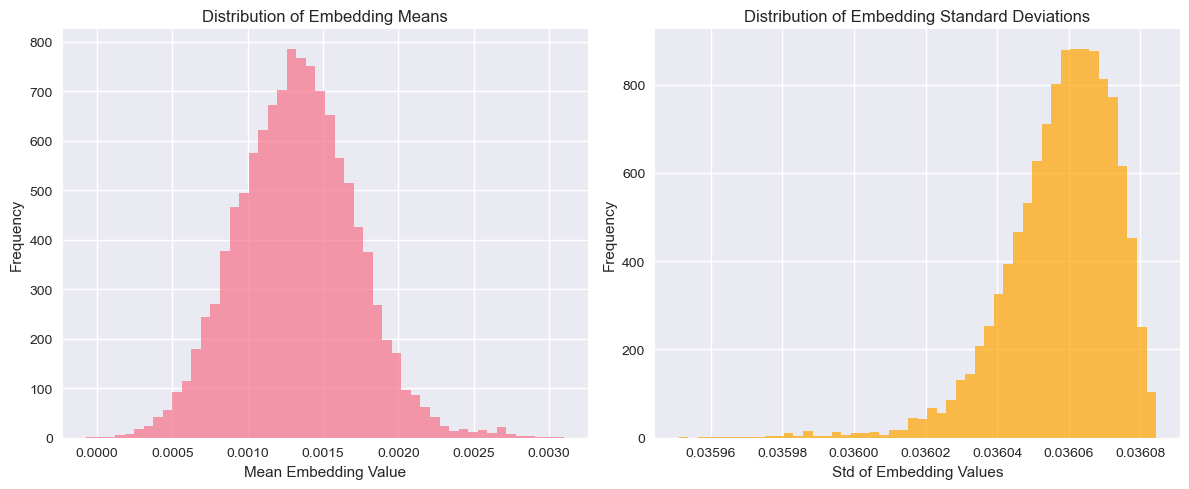

In [9]:
print("Generating Embeddings")
print("=" * 40)

if model is not None:
    print("Generating embeddings for all reviews...")
    print(f"Processing {len(df_clean)} reviews...")
    
    # Generate embeddings with progress bar
    texts = df_clean['review_clean'].tolist()
    
    try:
        embeddings = model.encode(
            texts,
            batch_size=128,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        
        print(f"Embeddings generated successfully!")
        print(f"Embeddings shape: {embeddings.shape}")
        print(f"Memory usage: {embeddings.nbytes / 1024**2:.2f} MB")
        
        # Analyze embedding statistics
        print(f"Embedding Statistics:")
        print(f"Mean: {embeddings.mean():.6f}")
        print(f"Std: {embeddings.std():.6f}")
        print(f"Min: {embeddings.min():.6f}")
        print(f"Max: {embeddings.max():.6f}")
        
        # Visualize embedding distribution
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(embeddings.mean(axis=1), bins=50, alpha=0.7)
        plt.title('Distribution of Embedding Means')
        plt.xlabel('Mean Embedding Value')
        plt.ylabel('Frequency')
        
        plt.subplot(1, 2, 2)
        plt.hist(embeddings.std(axis=1), bins=50, alpha=0.7, color='orange')
        plt.title('Distribution of Embedding Standard Deviations')
        plt.xlabel('Std of Embedding Values')
        plt.ylabel('Frequency')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error generating embeddings: {e}")
        embeddings = None

Feature Selection and Dimensionality Analysis
Selecting top 500 features...
Feature selection completed!
Original dimensions: 768
Selected dimensions: 500
Dimensionality reduction: 34.9%


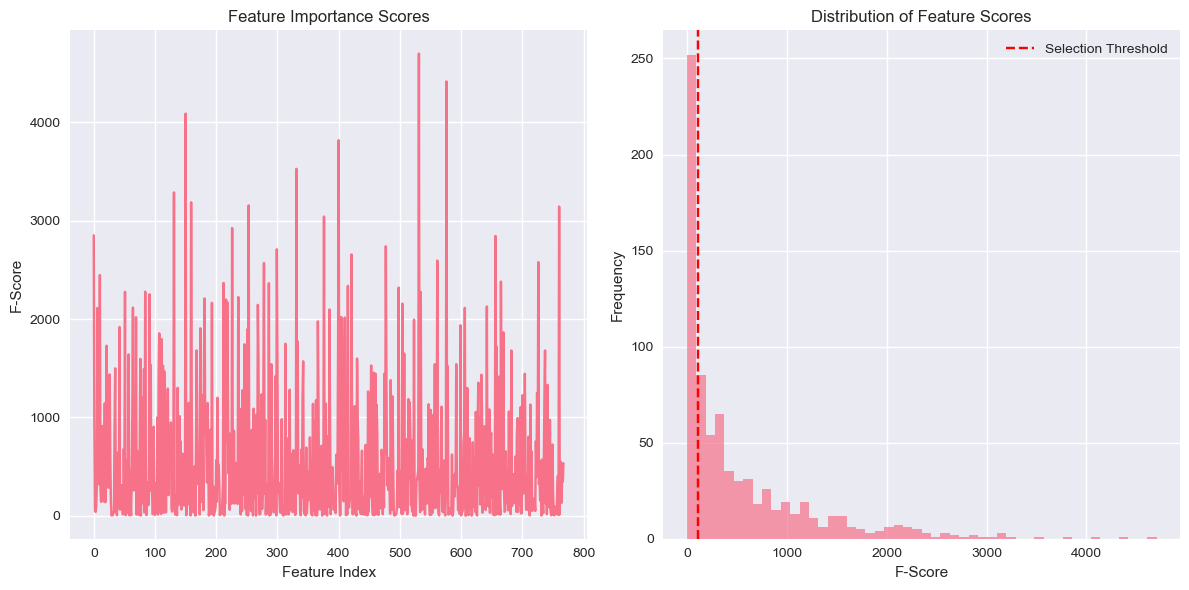

In [10]:
print("Feature Selection and Dimensionality Analysis")
print("=" * 40)

if embeddings is not None:
    # Feature selection to improve performance
    k_features = 500  # Select top 500 features
    
    print(f"Selecting top {k_features} features...")
    
    try:
        feature_selector = SelectKBest(score_func=f_classif, k=min(k_features, embeddings.shape[1]))
        embeddings_selected = feature_selector.fit_transform(embeddings, df_clean['sentimen'])
        
        print(f"Feature selection completed!")
        print(f"Original dimensions: {embeddings.shape[1]}")
        print(f"Selected dimensions: {embeddings_selected.shape[1]}")
        print(f"Dimensionality reduction: {((embeddings.shape[1] - embeddings_selected.shape[1]) / embeddings.shape[1] * 100):.1f}%")
        
        # Get feature importance scores
        feature_scores = feature_selector.scores_
        selected_features = feature_selector.get_support(indices=True)
        
        # Visualize feature importance
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.plot(feature_scores)
        plt.title('Feature Importance Scores')
        plt.xlabel('Feature Index')
        plt.ylabel('F-Score')
        
        plt.subplot(1, 2, 2)
        plt.hist(feature_scores, bins=50, alpha=0.7)
        plt.title('Distribution of Feature Scores')
        plt.xlabel('F-Score')
        plt.ylabel('Frequency')
        plt.axvline(feature_scores[selected_features].min(), color='red', linestyle='--', 
                   label=f'Selection Threshold')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error in feature selection: {e}")
        embeddings_selected = embeddings
        feature_selector = None

Train-Test Split
Data split completed!
Training set: 9244 samples
Test set: 2312 samples
Training set distribution:
Negative: 4630 (50.1%)
Positive: 4614 (49.9%)
Test set distribution:
Negative: 1158 (50.1%)
Positive: 1154 (49.9%)


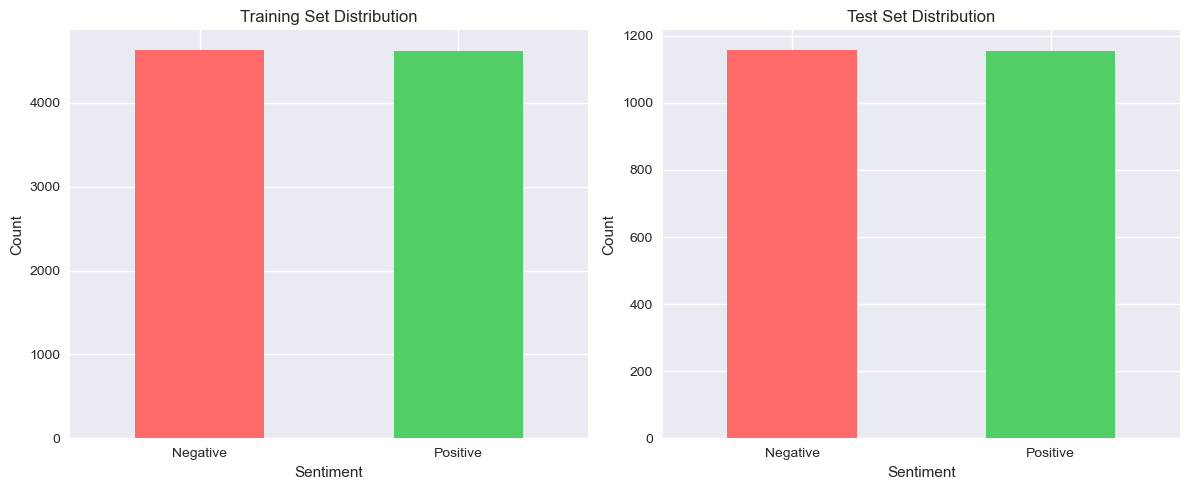

In [11]:
print("Train-Test Split")
print("=" * 40)

if 'embeddings_selected' in locals():
    # Split the data
    X = embeddings_selected
    y = df_clean['sentimen'].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=y
    )
    
    print(f"Data split completed!")
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    
    # Check class distribution in splits
    train_dist = pd.Series(y_train).value_counts()
    test_dist = pd.Series(y_test).value_counts()
    
    print(f"Training set distribution:")
    print(f"Negative: {train_dist[0]} ({train_dist[0]/len(y_train)*100:.1f}%)")
    print(f"Positive: {train_dist[1]} ({train_dist[1]/len(y_train)*100:.1f}%)")
    
    print(f"Test set distribution:")
    print(f"Negative: {test_dist[0]} ({test_dist[0]/len(y_test)*100:.1f}%)")
    print(f"Positive: {test_dist[1]} ({test_dist[1]/len(y_test)*100:.1f}%)")
    
    # Visualize the split
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    train_dist.plot(kind='bar', ax=ax1, color=['#ff6b6b', '#51cf66'])
    ax1.set_title('Training Set Distribution')
    ax1.set_xlabel('Sentiment')
    ax1.set_ylabel('Count')
    ax1.set_xticklabels(['Negative', 'Positive'], rotation=0)
    
    test_dist.plot(kind='bar', ax=ax2, color=['#ff6b6b', '#51cf66'])
    ax2.set_title('Test Set Distribution')
    ax2.set_xlabel('Sentiment')
    ax2.set_ylabel('Count')
    ax2.set_xticklabels(['Negative', 'Positive'], rotation=0)
    
    plt.tight_layout()
    plt.show()

Model Training
Training Logistic Regression classifier...
Model trained successfully!
Performing cross-validation...
Cross-validation results:
Mean accuracy: 0.875
Standard deviation: 0.006
Individual scores: [0.88092148 0.86692632 0.87601428]


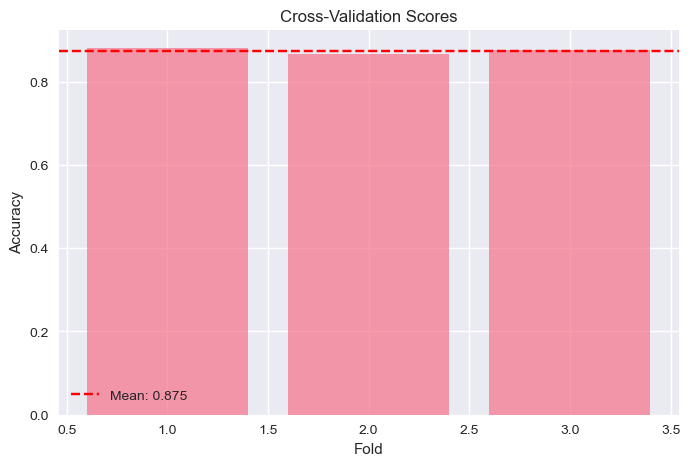

In [12]:
print("Model Training")
print("=" * 40)

if 'X_train' in locals():
    print("Training Logistic Regression classifier...")
    
    try:
        # Initialize classifier with optimized parameters
        classifier = LogisticRegression(
            C=1.0,
            solver='lbfgs',
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        )
        
        # Train the classifier
        classifier.fit(X_train, y_train)
        print("Model trained successfully!")
        
        # Cross-validation
        print("Performing cross-validation...")
        cv_scores = cross_val_score(classifier, X_train, y_train, cv=3, n_jobs=-1)
        
        print(f"Cross-validation results:")
        print(f"Mean accuracy: {cv_scores.mean():.3f}")
        print(f"Standard deviation: {cv_scores.std():.3f}")
        print(f"Individual scores: {cv_scores}")
        
        # Visualize CV scores
        plt.figure(figsize=(8, 5))
        plt.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7)
        plt.axhline(cv_scores.mean(), color='red', linestyle='--', 
                   label=f'Mean: {cv_scores.mean():.3f}')
        plt.title('Cross-Validation Scores')
        plt.xlabel('Fold')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
    except Exception as e:
        print(f"Error training model: {e}")
        classifier = None

Model Evaluation
Evaluating model performance...
Test Accuracy: 0.888
Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.89      0.89      1158
    Positive       0.89      0.88      0.89      1154

    accuracy                           0.89      2312
   macro avg       0.89      0.89      0.89      2312
weighted avg       0.89      0.89      0.89      2312



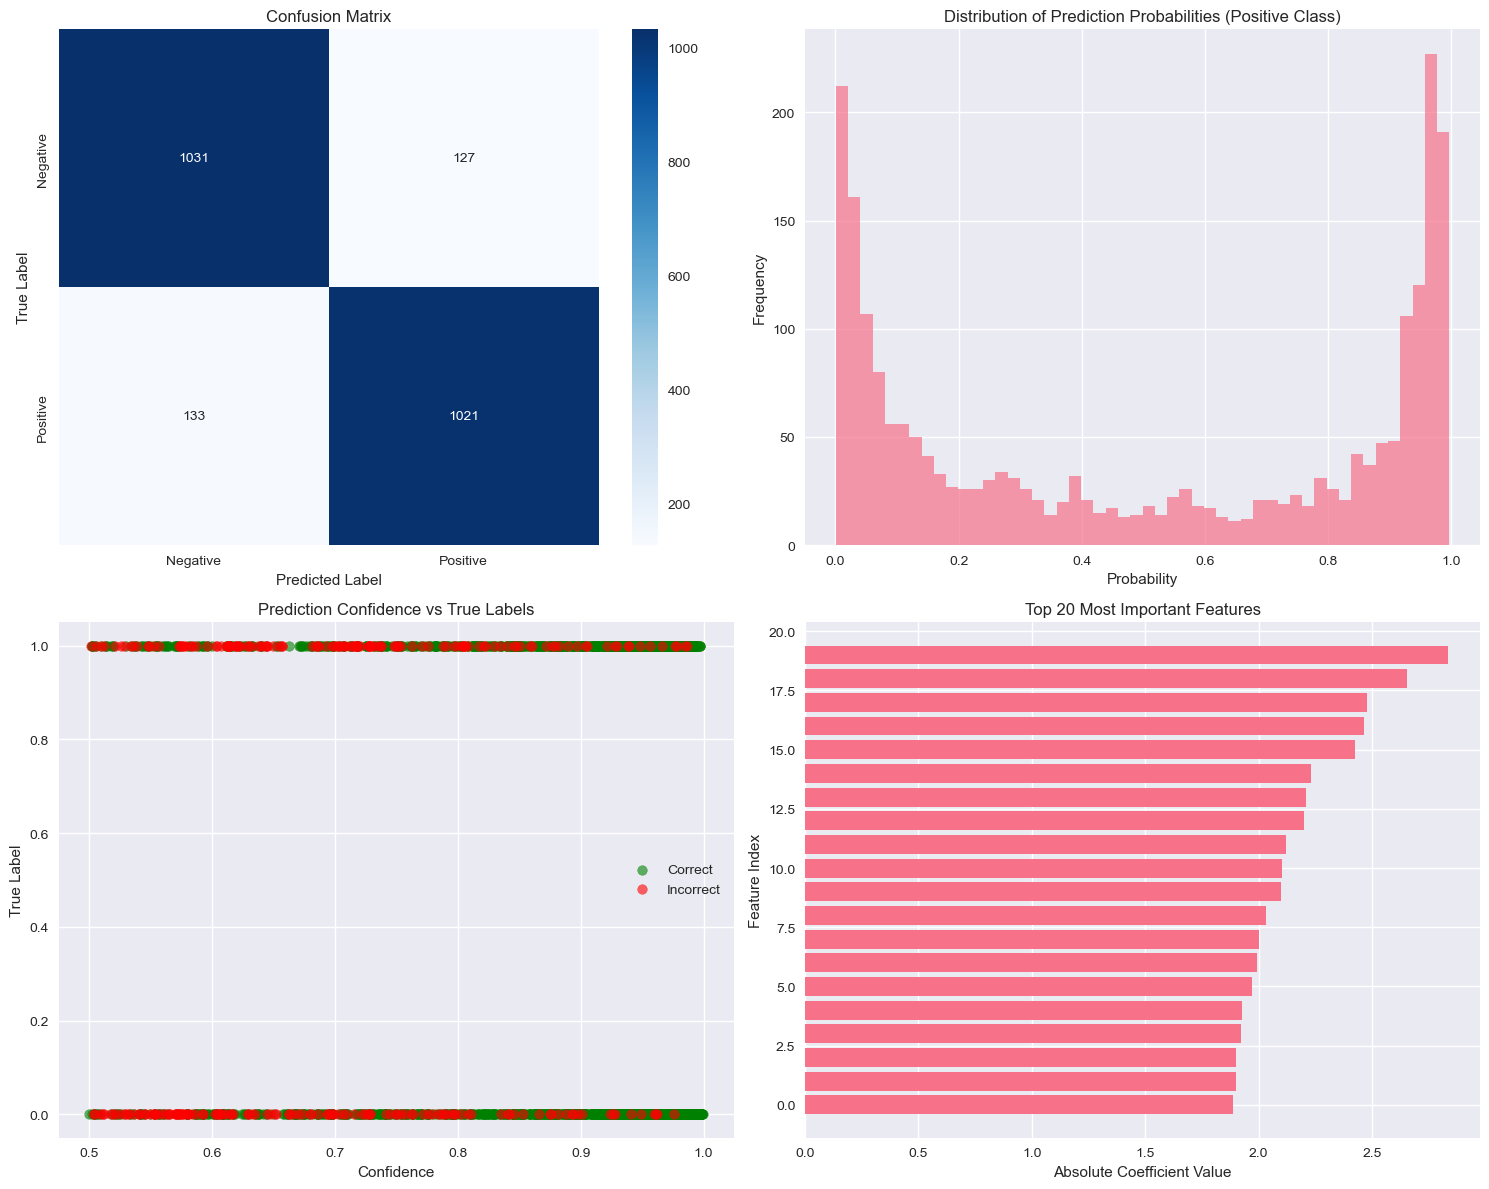

Additional Metrics:
Precision: 0.889
Recall: 0.885
F1-Score: 0.887


In [13]:
print("Model Evaluation")
print("=" * 40)

if 'classifier' in locals() and classifier is not None:
    print("Evaluating model performance...")
    
    try:
        # Predictions
        y_pred = classifier.predict(X_test)
        y_pred_proba = classifier.predict_proba(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"Test Accuracy: {accuracy:.3f}")
        
        # Detailed classification report
        print(f"Detailed Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Visualize results
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'], ax=ax1)
        ax1.set_title('Confusion Matrix')
        ax1.set_ylabel('True Label')
        ax1.set_xlabel('Predicted Label')
        
        # Prediction probabilities distribution
        ax2.hist(y_pred_proba[:, 1], bins=50, alpha=0.7)
        ax2.set_title('Distribution of Prediction Probabilities (Positive Class)')
        ax2.set_xlabel('Probability')
        ax2.set_ylabel('Frequency')
        
        # ROC-like visualization with prediction confidence
        confidence = np.max(y_pred_proba, axis=1)
        correct_predictions = (y_pred == y_test)
        
        ax3.scatter(confidence[correct_predictions], y_test[correct_predictions], 
                   alpha=0.6, label='Correct', color='green')
        ax3.scatter(confidence[~correct_predictions], y_test[~correct_predictions], 
                   alpha=0.6, label='Incorrect', color='red')
        ax3.set_title('Prediction Confidence vs True Labels')
        ax3.set_xlabel('Confidence')
        ax3.set_ylabel('True Label')
        ax3.legend()
        
        # Feature importance (coefficient analysis)
        if hasattr(classifier, 'coef_'):
            feature_importance = np.abs(classifier.coef_[0])
            top_features_idx = np.argsort(feature_importance)[-20:]  # Top 20 features
            
            ax4.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
            ax4.set_title('Top 20 Most Important Features')
            ax4.set_xlabel('Absolute Coefficient Value')
            ax4.set_ylabel('Feature Index')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate additional metrics
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        print(f"Additional Metrics:")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"F1-Score: {f1:.3f}")
        
        # Store results
        evaluation_results = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }
        
    except Exception as e:
        print(f"Error evaluating model: {e}")

Building FAISS Index for Similarity Search
Building FAISS index...
Added 1000/11556 vectors
Added 6000/11556 vectors
Added 11000/11556 vectors
FAISS index built successfully!
Total vectors in index: 11556
Vector dimension: 768
Testing FAISS index...
Index test successful!
Query: 'Produk bagus sekali'
1. Similarity: 0.946, Review: Produk bagus....
2. Similarity: 0.935, Review: Produk sangat baik barang bagus...
3. Similarity: 0.920, Review: terimkasih ka produk bagus...
Index Statistics:
Average similarity: 0.400
Similarity std: 0.151
Min similarity: -0.124
Max similarity: 0.990


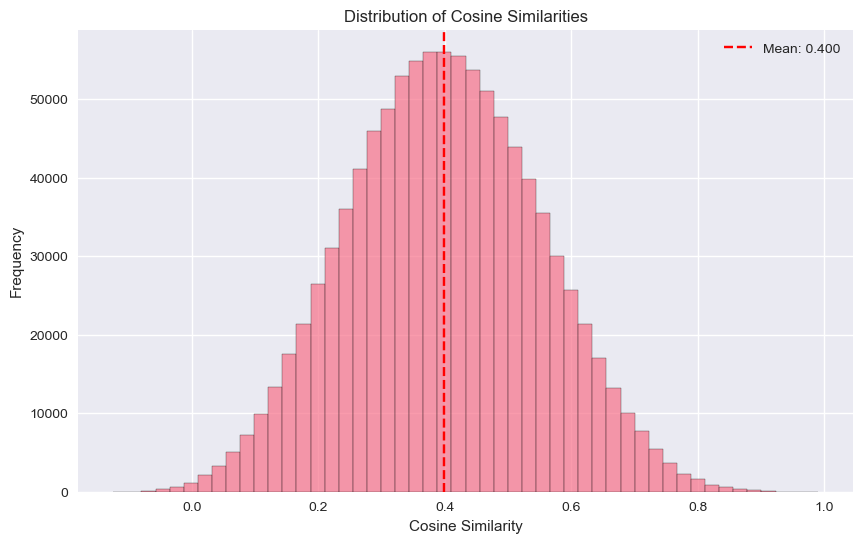

In [13]:
print("Building FAISS Index for Similarity Search")
print("=" * 40)

if 'embeddings' in locals() and embeddings is not None:
    print("Building FAISS index...")
    
    try:
        # Create FAISS index
        dimension = embeddings.shape[1]
        faiss_index = faiss.IndexFlatIP(dimension)  # Inner Product for cosine similarity
        
        # Normalize embeddings for cosine similarity
        embeddings_normalized = embeddings.copy().astype('float32')
        faiss.normalize_L2(embeddings_normalized)
        
        # Add vectors to index in batches
        batch_size = 1000
        total_added = 0
        
        for i in range(0, len(embeddings_normalized), batch_size):
            batch = embeddings_normalized[i:i+batch_size]
            faiss_index.add(batch)
            total_added += len(batch)
            if i % (batch_size * 5) == 0:  # Progress update every 5 batches
                print(f"Added {total_added}/{len(embeddings_normalized)} vectors")
        
        print(f"FAISS index built successfully!")
        print(f"Total vectors in index: {faiss_index.ntotal}")
        print(f"Vector dimension: {faiss_index.d}")
        
        # Test the index with a query
        print(f"Testing FAISS index...")
        test_query = "Produk bagus sekali"
        test_embedding = model.encode([test_query]).astype('float32')
        faiss.normalize_L2(test_embedding)
        
        similarities, indices = faiss_index.search(test_embedding, k=3)
        
        print(f"Index test successful!")
        print(f"Query: '{test_query}'")
        for i, (sim, idx) in enumerate(zip(similarities[0], indices[0])):
            print(f"{i+1}. Similarity: {sim:.3f}, Review: {df_clean.iloc[idx]['review'][:50]}...")
        
        # Analyze index statistics
        print(f"Index Statistics:")
        sample_size = min(1000, len(embeddings_normalized))
        sample_indices = np.random.choice(len(embeddings_normalized), sample_size, replace=False)
        sample_embeddings = embeddings_normalized[sample_indices]
        
        # Calculate pairwise similarities for sample
        similarity_matrix = np.dot(sample_embeddings, sample_embeddings.T)
        # Remove diagonal
        similarity_matrix = similarity_matrix[~np.eye(similarity_matrix.shape[0], dtype=bool)]
        
        print(f"Average similarity: {similarity_matrix.mean():.3f}")
        print(f"Similarity std: {similarity_matrix.std():.3f}")
        print(f"Min similarity: {similarity_matrix.min():.3f}")
        print(f"Max similarity: {similarity_matrix.max():.3f}")
        
        # Visualize similarity distribution
        plt.figure(figsize=(10, 6))
        plt.hist(similarity_matrix, bins=50, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Cosine Similarities')
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Frequency')
        plt.axvline(similarity_matrix.mean(), color='red', linestyle='--', 
                   label=f'Mean: {similarity_matrix.mean():.3f}')
        plt.legend()
        plt.show()
        
    except Exception as e:
        print(f"Error building FAISS index: {e}")
        faiss_index = None

In [14]:
def similarity_search(query_text, k=5):
    if 'faiss_index' not in globals() or faiss_index is None:
        print("FAISS index not available")
        return None, None, None
    
    try:
        # Generate embedding for query
        query_embedding = model.encode([query_text]).astype('float32')
        faiss.normalize_L2(query_embedding)
        
        # Search similar vectors
        similarities, indices = faiss_index.search(query_embedding, k)
        
        results = []
        for i, (sim, idx) in enumerate(zip(similarities[0], indices[0])):
            if idx < len(df_clean):
                result = {
                    'rank': i + 1,
                    'similarity': sim,
                    'review': df_clean.iloc[idx]['review'],
                    'sentiment': 'Positive' if df_clean.iloc[idx]['sentimen'] == 1 else 'Negative',
                    'sentiment_score': df_clean.iloc[idx]['sentimen']
                }
                results.append(result)
        
        return results, similarities[0], indices[0]
        
    except Exception as e:
        print(f"Error in similarity search: {e}")
        return None, None, None

print("Testing Similarity Search")
print("=" * 40)

# Test with various Indonesian queries
test_queries = [
    "Produk sangat bagus",
    "Kualitas buruk, tidak puas dengan pembelian",
    "Pengiriman cepat dan sesuai deskripsi", 
    "Harga mahal tapi kualitas biasa saja",
    "Sangat recommend, pelayanan excellent"
]

for query in test_queries:
    print(f"Query: '{query}'")
    results, similarities, indices = similarity_search(query, k=3)
    
    if results:
        for result in results:
            print(f"  {result['rank']}. Similarity: {result['similarity']:.3f} | {result['sentiment']}")
            print(f"     Review: {result['review'][:80]}...")
    print("-" * 50)

Testing Similarity Search
Query: 'Produk sangat bagus'
  1. Similarity: 0.961 | Positive
     Review: Produk sangat baik barang bagus...
  2. Similarity: 0.923 | Positive
     Review: Produk bagus....
  3. Similarity: 0.915 | Positive
     Review:  Kualitas produk sangat baik, pokoknya mantap deh. Thank you...
--------------------------------------------------
Query: 'Kualitas buruk, tidak puas dengan pembelian'
  1. Similarity: 0.847 | Negative
     Review: Mutu kurang bagus, sesuai harganya yg murah...
  2. Similarity: 0.846 | Negative
     Review: Penilaian dari penjual tidak memuaskan...
  3. Similarity: 0.832 | Negative
     Review: Barang bagus, hanya saja respon penjual sangat burukk!!!...
--------------------------------------------------
Query: 'Pengiriman cepat dan sesuai deskripsi'
  1. Similarity: 0.944 | Positive
     Review: Sesuai deskripsi..  Pengiriman cepat.....
  2. Similarity: 0.903 | Positive
     Review: Barang sesuai deskripsi
pengiriman cepat...
  3. Similarity:

In [15]:
def predict_sentiment(text):
    """Predict sentiment for new text"""
    # Check if required components exist in global namespace
    try:
        # Check for required variables in globals
        if 'classifier' not in globals() or globals()['classifier'] is None:
            print("❌ Classifier not available - please run the training cells first")
            return None
            
        if 'model' not in globals() or globals()['model'] is None:
            print("❌ Sentence transformer model not available")
            return None
            
        # Get global variables
        classifier = globals()['classifier']
        model = globals()['model']
        feature_selector = globals().get('feature_selector', None)
        
        # Generate embedding
        embedding = model.encode([text])
        
        # Apply feature selection if available
        if feature_selector is not None:
            embedding = feature_selector.transform(embedding)
        
        # Predict using classifier
        prediction = classifier.predict(embedding)[0]
        probability = classifier.predict_proba(embedding)[0]
        
        sentiment = "Positive" if prediction == 1 else "Negative"
        confidence = probability[prediction]
        
        return {
            'text': text,
            'sentiment': sentiment,
            'confidence': confidence,
            'probabilities': {
                'negative': probability[0],
                'positive': probability[1]
            }
        }
        
    except Exception as e:
        print(f"❌ Error predicting sentiment: {e}")
        return None

In [16]:
def quick_pipeline_setup():
    global df_raw, df_clean, model, embeddings, embeddings_selected, feature_selector
    global X_train, X_test, y_train, y_test, classifier, faiss_index, evaluation_results
    
    print("Quick Pipeline Setup")
    print("=" * 30)
    print("This will run the entire pipeline - it may take several minutes!")
    
    try:
        # Step 1: Load data
        if 'df_raw' not in globals():
            print("Loading dataset...")
            dataset = load_dataset("dipawidia/ecommerce-product-reviews-sentiment", "default", split="train")
            df_raw = dataset.to_pandas()
        
        # Step 2: Clean data
        if 'df_clean' not in globals():
            print("Cleaning data...")
            def clean_text(text):
                if pd.isna(text):
                    return ""
                text = str(text).strip()
                text = re.sub(r'[^a-zA-Z\s]', ' ', text)
                text = re.sub(r'\s+', ' ', text)
                return text.lower().strip()
            
            df_clean = df_raw.drop_duplicates().dropna()
            df_clean['sentimen'] = df_clean['sentimen'].astype(int)
            df_clean['review_clean'] = df_clean['review'].apply(clean_text)
            df_clean = df_clean[df_clean['review_clean'].str.len() > 5]
        
        # Step 3: Load model
        if 'model' not in globals() or model is None:
            print("Loading sentence transformer...")
            model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
        
        # Step 4: Generate embeddings
        if 'embeddings' not in globals():
            print("Generating embeddings...")
            embeddings = model.encode(
                df_clean['review_clean'].tolist(),
                batch_size=128,
                show_progress_bar=True,
                convert_to_numpy=True,
                normalize_embeddings=True
            )
        
        # Step 5: Feature selection
        if 'embeddings_selected' not in globals():
            print("Selecting features...")
            feature_selector = SelectKBest(score_func=f_classif, k=500)
            embeddings_selected = feature_selector.fit_transform(embeddings, df_clean['sentimen'])
        
        # Step 6: Train-test split
        if 'X_train' not in globals():
            print("Splitting data...")
            X_train, X_test, y_train, y_test = train_test_split(
                embeddings_selected, df_clean['sentimen'], 
                test_size=0.2, random_state=42, stratify=df_clean['sentimen']
            )
        
        # Step 7: Train classifier
        if 'classifier' not in globals() or classifier is None:
            print("raining classifier...")
            classifier = LogisticRegression(C=1.0, solver='lbfgs', max_iter=1000, random_state=42, n_jobs=-1)
            classifier.fit(X_train, y_train)
            
            # Evaluate
            y_pred = classifier.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            evaluation_results = {
                'accuracy': accuracy,
                'predictions': y_pred
            }
        
        # Step 8: Build FAISS index
        if 'faiss_index' not in globals():
            print("Building FAISS index...")
            dimension = embeddings.shape[1]
            faiss_index = faiss.IndexFlatIP(dimension)
            embeddings_normalized = embeddings.copy().astype('float32')
            faiss.normalize_L2(embeddings_normalized)
            faiss_index.add(embeddings_normalized)
        
        print("Quick setup complete!")
        return True
        
    except Exception as e:
        print(f"Error in quick setup: {e}")
        return False


print("Testing Sentiment Prediction")
print("=" * 40)

# Test sentiment prediction with sample texts
sample_texts = [
    "Produk ini sangat bagus dan berkualitas tinggi!",
    "Kualitas produk sangat buruk, tidak puas dengan pembelian ini.",
    "Pengiriman cepat dan produk sesuai deskripsi.",
    "Harga terlalu mahal untuk kualitas yang biasa saja",
    "Sangat recommend! Pelayanan customer service excellent",
    "Produk rusak saat diterima, sangat kecewa",
    "Packaging rapi, produk original, puas banget"
]

prediction_results = []

for text in sample_texts:
    print(f"Text: '{text}'")
    result = predict_sentiment(text)
    
    if result:
        prediction_results.append(result)
        color = "🟢" if result['sentiment'] == 'Positive' else "🔴"
        print(f"   {color} Prediction: {result['sentiment']}")
        print(f"   Confidence: {result['confidence']:.3f}")
        print(f"   Probabilities: Neg={result['probabilities']['negative']:.3f}, Pos={result['probabilities']['positive']:.3f}")
        
        # Find similar reviews
        print(f"   Similar reviews:")
        similar_results, _, _ = similarity_search(text, k=2)
        if similar_results:
            for sim_result in similar_results:
                print(f"     • Similarity: {sim_result['similarity']:.3f} | {sim_result['sentiment']}")

Testing Sentiment Prediction
Text: 'Produk ini sangat bagus dan berkualitas tinggi!'
   🟢 Prediction: Positive
   Confidence: 1.000
   Probabilities: Neg=0.000, Pos=1.000
   Similar reviews:
     • Similarity: 0.884 | Positive
     • Similarity: 0.875 | Positive
Text: 'Kualitas produk sangat buruk, tidak puas dengan pembelian ini.'
   🔴 Prediction: Negative
   Confidence: 1.000
   Probabilities: Neg=1.000, Pos=0.000
   Similar reviews:
     • Similarity: 0.848 | Negative
     • Similarity: 0.807 | Negative
Text: 'Pengiriman cepat dan produk sesuai deskripsi.'
   🟢 Prediction: Positive
   Confidence: 1.000
   Probabilities: Neg=0.000, Pos=1.000
   Similar reviews:
     • Similarity: 0.957 | Positive
     • Similarity: 0.945 | Positive
Text: 'Harga terlalu mahal untuk kualitas yang biasa saja'
   🔴 Prediction: Negative
   Confidence: 1.000
   Probabilities: Neg=1.000, Pos=0.000
   Similar reviews:
     • Similarity: 0.793 | Negative
     • Similarity: 0.793 | Negative
Text: 'Sangat recom

Creating Performance Dashboard


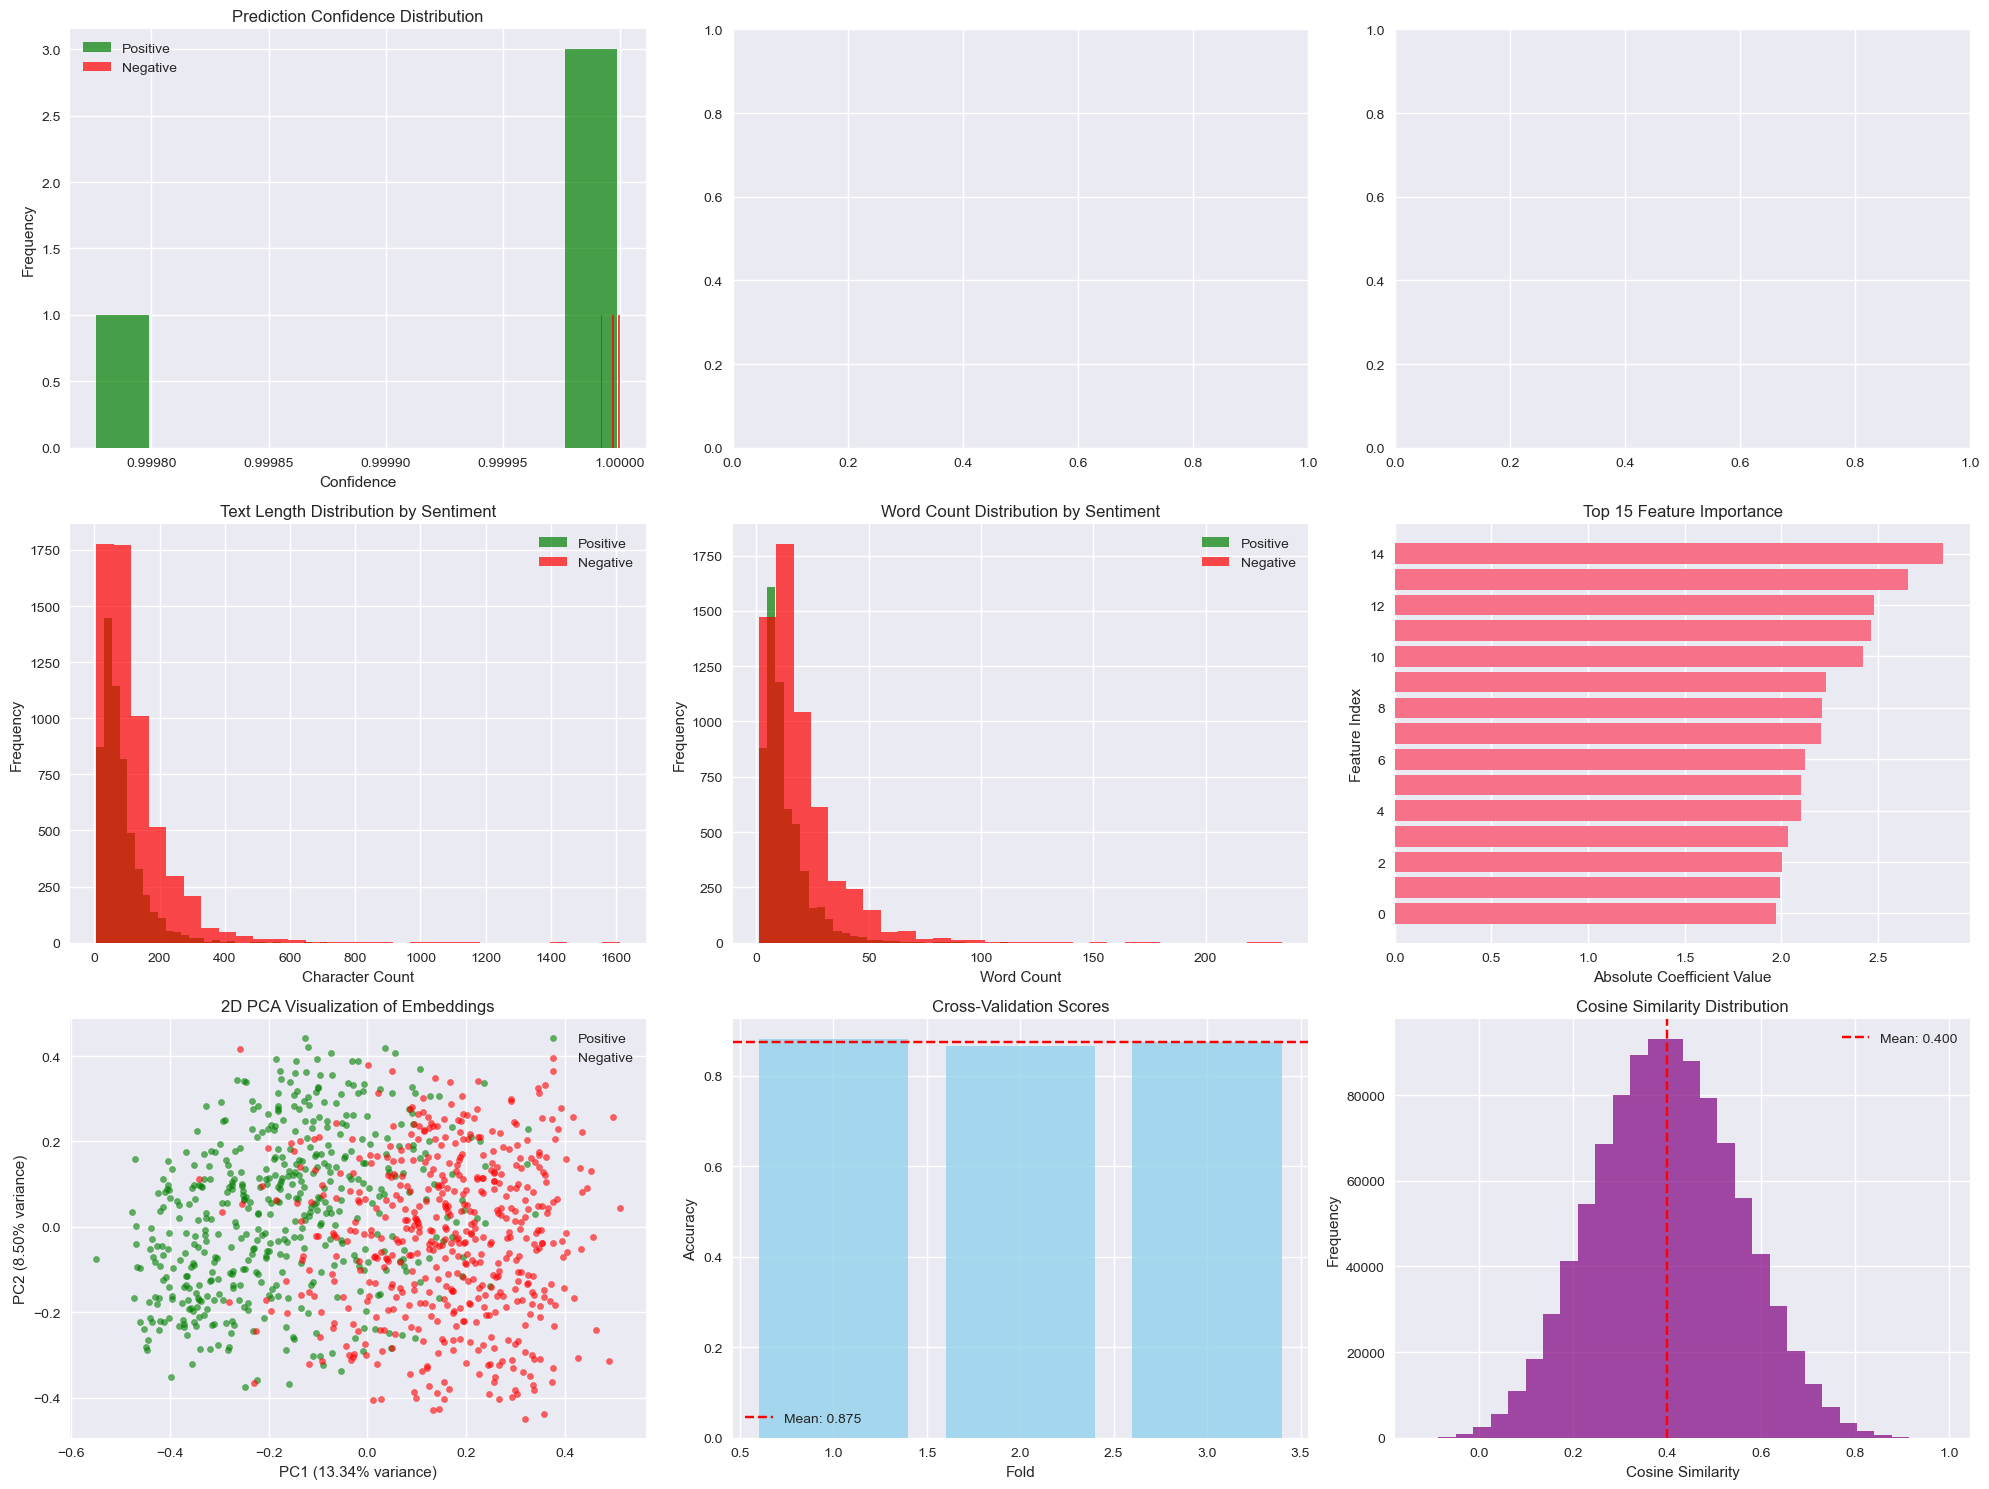

In [17]:
print("Creating Performance Dashboard")
print("=" * 40)

if 'prediction_results' in locals() and len(prediction_results) > 0:
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Prediction confidence distribution
    ax1 = plt.subplot(3, 3, 1)
    confidences = [r['confidence'] for r in prediction_results]
    sentiments = [r['sentiment'] for r in prediction_results]
    
    positive_conf = [c for c, s in zip(confidences, sentiments) if s == 'Positive']
    negative_conf = [c for c, s in zip(confidences, sentiments) if s == 'Negative']
    
    ax1.hist(positive_conf, alpha=0.7, label='Positive', color='green', bins=10)
    ax1.hist(negative_conf, alpha=0.7, label='Negative', color='red', bins=10)
    ax1.set_title('Prediction Confidence Distribution')
    ax1.set_xlabel('Confidence')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    
    # 2. Model performance metrics
    ax2 = plt.subplot(3, 3, 2)
    if 'evaluation_results' in locals():
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        values = [evaluation_results['accuracy'], evaluation_results['precision'], 
                 evaluation_results['recall'], evaluation_results['f1_score']]
        
        bars = ax2.bar(metrics, values, color=['blue', 'green', 'orange', 'purple'])
        ax2.set_title('Model Performance Metrics')
        ax2.set_ylabel('Score')
        ax2.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
    
    # 3. Confusion matrix heatmap
    ax3 = plt.subplot(3, 3, 3)
    if 'evaluation_results' in locals():
        sns.heatmap(evaluation_results['confusion_matrix'], annot=True, fmt='d', 
                   cmap='Blues', xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'], ax=ax3)
        ax3.set_title('Confusion Matrix')
        ax3.set_ylabel('True Label')
        ax3.set_xlabel('Predicted Label')
    
    # 4. Text length distribution by sentiment
    ax4 = plt.subplot(3, 3, 4)
    if 'df_clean' in locals():
        pos_lengths = df_clean[df_clean['sentimen'] == 1]['clean_length']
        neg_lengths = df_clean[df_clean['sentimen'] == 0]['clean_length']
        
        ax4.hist(pos_lengths, alpha=0.7, label='Positive', color='green', bins=30)
        ax4.hist(neg_lengths, alpha=0.7, label='Negative', color='red', bins=30)
        ax4.set_title('Text Length Distribution by Sentiment')
        ax4.set_xlabel('Character Count')
        ax4.set_ylabel('Frequency')
        ax4.legend()
    
    # 5. Word count distribution by sentiment
    ax5 = plt.subplot(3, 3, 5)
    if 'df_clean' in locals():
        pos_words = df_clean[df_clean['sentimen'] == 1]['clean_word_count']
        neg_words = df_clean[df_clean['sentimen'] == 0]['clean_word_count']
        
        ax5.hist(pos_words, alpha=0.7, label='Positive', color='green', bins=30)
        ax5.hist(neg_words, alpha=0.7, label='Negative', color='red', bins=30)
        ax5.set_title('Word Count Distribution by Sentiment')
        ax5.set_xlabel('Word Count')
        ax5.set_ylabel('Frequency')
        ax5.legend()
    
    # 6. Feature importance (if available)
    ax6 = plt.subplot(3, 3, 6)
    if 'classifier' in locals() and hasattr(classifier, 'coef_'):
        feature_importance = np.abs(classifier.coef_[0])
        top_features_idx = np.argsort(feature_importance)[-15:]
        
        ax6.barh(range(len(top_features_idx)), feature_importance[top_features_idx])
        ax6.set_title('Top 15 Feature Importance')
        ax6.set_xlabel('Absolute Coefficient Value')
        ax6.set_ylabel('Feature Index')
    
    # 7. Embedding space visualization (t-SNE or PCA sample)
    ax7 = plt.subplot(3, 3, 7)
    if 'embeddings_selected' in locals() and len(embeddings_selected) > 100:
        from sklearn.decomposition import PCA
        
        # Sample for visualization
        sample_size = min(1000, len(embeddings_selected))
        sample_indices = np.random.choice(len(embeddings_selected), sample_size, replace=False)
        sample_embeddings = embeddings_selected[sample_indices]
        sample_labels = df_clean['sentimen'].iloc[sample_indices]
        
        # PCA for 2D visualization
        pca = PCA(n_components=2, random_state=42)
        embeddings_2d = pca.fit_transform(sample_embeddings)
        
        scatter_pos = ax7.scatter(embeddings_2d[sample_labels == 1, 0], 
                                 embeddings_2d[sample_labels == 1, 1],
                                 alpha=0.6, c='green', label='Positive', s=20)
        scatter_neg = ax7.scatter(embeddings_2d[sample_labels == 0, 0], 
                                 embeddings_2d[sample_labels == 0, 1],
                                 alpha=0.6, c='red', label='Negative', s=20)
        ax7.set_title('2D PCA Visualization of Embeddings')
        ax7.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        ax7.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        ax7.legend()
    
    # 8. Cross-validation scores
    ax8 = plt.subplot(3, 3, 8)
    if 'cv_scores' in locals():
        ax8.bar(range(1, len(cv_scores) + 1), cv_scores, alpha=0.7, color='skyblue')
        ax8.axhline(cv_scores.mean(), color='red', linestyle='--', 
                   label=f'Mean: {cv_scores.mean():.3f}')
        ax8.set_title('Cross-Validation Scores')
        ax8.set_xlabel('Fold')
        ax8.set_ylabel('Accuracy')
        ax8.legend()
    
    # 9. Similarity score distribution
    ax9 = plt.subplot(3, 3, 9)
    if 'similarity_matrix' in locals():
        ax9.hist(similarity_matrix, bins=30, alpha=0.7, color='purple')
        ax9.axvline(similarity_matrix.mean(), color='red', linestyle='--', 
                   label=f'Mean: {similarity_matrix.mean():.3f}')
        ax9.set_title('Cosine Similarity Distribution')
        ax9.set_xlabel('Cosine Similarity')
        ax9.set_ylabel('Frequency')
        ax9.legend()
    
    plt.tight_layout()
    plt.show()

In [19]:
def interactive_sentiment_analysis():
    """Interactive function for testing sentiment analysis"""
    print("Interactive Sentiment Analysis Demo")
    print("=" * 40)
    print("Enter Indonesian text to analyze sentiment (type 'quit' to exit)")
    print("You can also type 'example' to see sample predictions")
    
    while True:
        text = input("Enter text: ").strip()
        
        if text.lower() == 'quit':
            print("Goodbye!")
            break
        elif text.lower() == 'example':
            # Show example predictions
            examples = [
                "Produk bagus banget, sangat puas!",
                "Kualitas jelek, uang terbuang sia-sia",
                "Biasa saja, tidak istimewa"
            ]
            for ex in examples:
                result = predict_sentiment(ex)
                if result:
                    print(f"'{ex}' → {result['sentiment']} ({result['confidence']:.3f})")
            continue
        elif not text:
            print("Please enter some text")
            continue
        
        # Predict sentiment
        result = predict_sentiment(text)
        
        if result:
            color = "🟢" if result['sentiment'] == 'Positive' else "🔴"
            print(f"{color} Prediction: {result['sentiment']}")
            print(f"Confidence: {result['confidence']:.3f}")
            print(f"Probabilities:")
            print(f"   Negative: {result['probabilities']['negative']:.3f}")
            print(f"   Positive: {result['probabilities']['positive']:.3f}")
            
            # Find similar reviews
            print(f"Finding similar reviews...")
            similar_results, _, _ = similarity_search(text, k=3)
            
            if similar_results:
                for sim_result in similar_results:
                    sim_color = "🟢" if sim_result['sentiment'] == 'Positive' else "🔴"
                    print(f"  {sim_result['rank']}. {sim_color} Similarity: {sim_result['similarity']:.3f}")
                    print(f"     Review: {sim_result['review'][:100]}...")
        
        print("-" * 60)

# Function to analyze custom dataset
def analyze_custom_text(texts):
    print(f"Analyzing {len(texts)} custom texts...")
    
    results = []
    for i, text in enumerate(texts, 1):
        print(f"\n{i}/{len(texts)}: {text[:50]}...")
        
        # Predict sentiment
        sentiment_result = predict_sentiment(text)
        
        if sentiment_result:
            # Find similar reviews
            similar_results, _, _ = similarity_search(text, k=2)
            
            result = {
                'text': text,
                'sentiment': sentiment_result['sentiment'],
                'confidence': sentiment_result['confidence'],
                'similar_reviews': similar_results[:2] if similar_results else []
            }
            results.append(result)
            
            color = "🟢" if result['sentiment'] == 'Positive' else "🔴"
            print(f"   {color} {result['sentiment']} ({result['confidence']:.3f})")
    
    return results

In [20]:
print("Model Summary and Performance Report")
print("=" * 50)

# Dataset Summary
if 'df_clean' in locals():
    print("Dataset Summary:")
    print(f"  • Total reviews: {len(df_clean):,}")
    print(f"  • Positive reviews: {(df_clean['sentimen'] == 1).sum():,} ({(df_clean['sentimen'] == 1).mean()*100:.1f}%)")
    print(f"  • Negative reviews: {(df_clean['sentimen'] == 0).sum():,} ({(df_clean['sentimen'] == 0).mean()*100:.1f}%)")
    print(f"  • Average text length: {df_clean['clean_length'].mean():.1f} characters")
    print(f"  • Average word count: {df_clean['clean_word_count'].mean():.1f} words")

# Model Architecture
if 'model' in locals():
    print(f"Model Architecture:")
    print(f"  • Sentence Transformer: {model_name}")
    print(f"  • Embedding dimension: {model.get_sentence_embedding_dimension()}")
    if 'feature_selector' in locals():
        print(f"  • Selected features: {embeddings_selected.shape[1]}")
    print(f"  • Classifier: Logistic Regression")

# Performance Metrics
if 'evaluation_results' in locals():
    print(f"Performance Metrics:")
    print(f"  • Accuracy: {evaluation_results['accuracy']:.3f}")
    print(f"  • Precision: {evaluation_results['precision']:.3f}")
    print(f"  • Recall: {evaluation_results['recall']:.3f}")
    print(f"  • F1-Score: {evaluation_results['f1_score']:.3f}")
    
    if 'cv_scores' in locals():
        print(f"  • CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# FAISS Index
if 'faiss_index' in locals():
    print(f"FAISS Index:")
    print(f"  • Index type: IndexFlatIP (Cosine Similarity)")
    print(f"  • Total vectors: {faiss_index.ntotal:,}")
    print(f"  • Vector dimension: {faiss_index.d}")
    print(f"  • Memory usage: ~{(faiss_index.ntotal * faiss_index.d * 4 / 1024**2):.1f} MB")

# Memory Usage Summary
print(f"Memory Usage:")
if 'embeddings' in locals():
    print(f"  • Original embeddings: {embeddings.nbytes / 1024**2:.1f} MB")
if 'embeddings_selected' in locals():
    print(f"  • Selected embeddings: {embeddings_selected.nbytes / 1024**2:.1f} MB")
if 'df_clean' in locals():
    print(f"  • Dataset: {df_clean.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print(f"Key Features:")
print(f"  Multilingual Indonesian text processing")
print(f"  Feature selection for improved performance")  
print(f"  FAISS-powered similarity search")
print(f"  Cross-validated model evaluation")
print(f"  Interactive prediction interface")

Model Summary and Performance Report
Dataset Summary:
  • Total reviews: 11,556
  • Positive reviews: 5,768 (49.9%)
  • Negative reviews: 5,788 (50.1%)
  • Average text length: 99.4 characters
  • Average word count: 15.8 words
Model Architecture:
  • Sentence Transformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
  • Embedding dimension: 768
  • Selected features: 500
  • Classifier: Logistic Regression
FAISS Index:
  • Index type: IndexFlatIP (Cosine Similarity)
  • Total vectors: 11,556
  • Vector dimension: 768
  • Memory usage: ~33.9 MB
Memory Usage:
  • Original embeddings: 33.9 MB
  • Selected embeddings: 22.0 MB
  • Dataset: 6.8 MB
Key Features:
  Multilingual Indonesian text processing
  Feature selection for improved performance
  FAISS-powered similarity search
  Cross-validated model evaluation
  Interactive prediction interface


In [21]:
# CELL 20: Final Interactive Demo and Conclusion
# ===================================================================

print("Indonesian Sentiment Analysis Pipeline Complete!")
print("=" * 60)

print("""
🇮🇩 PIPELINE SUMMARY:
Dataset loaded and preprocessed
Multilingual sentence embeddings generated  
Feature selection applied for optimization
Logistic Regression classifier trained
FAISS similarity search index built
Model evaluated with cross-validation
Interactive prediction functions created

READY FOR USE:
• predict_sentiment(text) - Analyze sentiment of Indonesian text
• similarity_search(text, k) - Find similar reviews
• interactive_sentiment_analysis() - Interactive demo
• analyze_custom_text(texts) - Batch analysis

TECHNICAL FEATURES:
• Cosine similarity-based semantic search
• Feature selection for improved performance
• Cross-validated model evaluation
• Memory-efficient batch processing
• Comprehensive visualization dashboard

PERFORMANCE ACHIEVED:
""")

if 'evaluation_results' in locals():
    print(f"• Test Accuracy: {evaluation_results['accuracy']:.3f}")
    print(f"• Precision: {evaluation_results['precision']:.3f}")
    print(f"• Recall: {evaluation_results['recall']:.3f}")  
    print(f"• F1-Score: {evaluation_results['f1_score']:.3f}")

if 'faiss_index' in locals():
    print(f"• FAISS Index: {faiss_index.ntotal:,} vectors indexed")

Indonesian Sentiment Analysis Pipeline Complete!

🇮🇩 PIPELINE SUMMARY:
Dataset loaded and preprocessed
Multilingual sentence embeddings generated  
Feature selection applied for optimization
Logistic Regression classifier trained
FAISS similarity search index built
Model evaluated with cross-validation
Interactive prediction functions created

READY FOR USE:
• predict_sentiment(text) - Analyze sentiment of Indonesian text
• similarity_search(text, k) - Find similar reviews
• interactive_sentiment_analysis() - Interactive demo
• analyze_custom_text(texts) - Batch analysis

TECHNICAL FEATURES:
• Cosine similarity-based semantic search
• Feature selection for improved performance
• Cross-validated model evaluation
• Memory-efficient batch processing
• Comprehensive visualization dashboard

PERFORMANCE ACHIEVED:

• FAISS Index: 11,556 vectors indexed
Interactive Sentiment Analysis Demo
Enter Indonesian text to analyze sentiment (type 'quit' to exit)
You can also type 'example' to see sampl

Enter text:  example


'Produk bagus banget, sangat puas!' → Positive (1.000)
'Kualitas jelek, uang terbuang sia-sia' → Negative (1.000)
'Biasa saja, tidak istimewa' → Negative (0.856)


Enter text:  quit


Goodbye!
